# OFDM with QAM Modulation - Transmitter

Bit stream -> M-QAM -> OFDM -> Noise -> Visualizations 



In [479]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.io import savemat
import os
ifft_size = 720 # FFT size = number of subcarriers 
cp_length = 80
num_symbols = 20
mod_order = 16 # modulation order (e.g., 16-QAM)
num_active = 109 # number of active subcarriers 

Ld = ifft_size
Ls = Ld + cp_length 
dc_index = ifft_size // 2 
half = num_active // 2
active_subcarriers = list(range(dc_index - half, dc_index)) + \
                     list(range(dc_index + 1, dc_index + half + 1))


ifft_size = 720: This determines the total number of subcarriers (both active and inactive) in each OFDM symbol. 

You can think of this as the size of your frequency grid — you have 720 "slots" in the frequency domain.

cp_length = 80: Length of the cyclic prefix added to each OFDM symbol (used to combat ISI).

num_symbols = 20: This refers to the number of OFDM time-domain symbols you generate in total — i.e., how many different time samples (each one made from 720 subcarriers) you will create.

M-QAM: This tells us that each active subcarrier carries \(log_2(M)\) bits per OFDM symbol 

Think of it like a matrix:

- Each row is an OFDM symbol in time (20 total).
- Each column is a subcarrier (720 total, but maybe only ~109 are "active").

So we have 

$[720 subcarriers × 20 symbols]$

structure before applying IFFT + CP.

Each OFDM symbol uses the full set of subcarriers (but not all need to be modulated — often you zero-out the edges or DC).

Why 109 active subcarriers? 

The choice of 109 active subcarriers is arbitrary and design-dependent — it's not fixed by the IFFT size (720).

Even though your IFFT size is 720, not all subcarriers are used for data transmission.

DC Subcarrier (Center Frequency): The subcarrier at index 720/2 +1 = 361, corresponds to 0 Hz (DC), it is not used because it causes interference and no information is transmitted at 0 Hz.

Guard Bands: Subcarriers at the edges of the IFFT spectrum are usually zero-padded (i.e., set to 0) to prevent spectral leakage and simplify filtering. These are called guard subcarriers. This is especially important when OFDM signals are adjacent to other channels (e.g., LTE or WiFi).

Pilot Subcarriers (optional): Some subcarriers are used for channel estimation and synchronization — they don't carry data but help the receiver align and equalize.

\begin{array}{|l|c|l|}
\hline
\textbf{Region} & \textbf{Subcarrier Indices} & \textbf{Purpose} \\
\hline
\text{1. Guard (left)} & 1\text{ to }306 & \text{Zero-padded (guard)} \\
\text{2. Active (lower)} & 307\text{ to }360 & \text{QPSK data} \\
\text{3. DC} & 361 & \text{Explicitly nulled} \\
\text{4. Active (upper)} & 362\text{ to }415 & \text{QPSK data} \\
\text{5. Guard (right)} & 416\text{ to }720 & \text{Zero-padded (guard)} \\
\hline
\end{array}





### General M-QAM Mapping 

#### M-QAM Mapping

In **square M-QAM**, the constellation is a square grid:

* For **16-QAM**, the grid is $4 \times 4$
* For **64-QAM**, it's $8 \times 8$

That means:

* Half the bits control the **in-phase (I)** component
* Half control the **quadrature (Q)** component


#### 1. `bits_per_axis = bits_per_symbol // 2`

This divides the total bits per symbol equally between the **I** and **Q** axes.

| Modulation | bits\_per\_symbol | bits\_per\_axis |
| ---------- | ----------------- | --------------- |
| QPSK (4)   | 2                 | 1               |
| 16-QAM     | 4                 | 2               |
| 64-QAM     | 6                 | 3               |

So:

* Each **QAM symbol** = `bits_per_symbol` bits
* $2^{\text{bits\_per\_axis}}$ levels per axis


#### 2. `M_axis = sqrt(mod_order)`

This calculates the number of levels **per dimension** in the constellation.

| mod\_order | M\_axis |
| ---------- | ------- |
| 4          | 2       |
| 16         | 4       |
| 64         | 8       |

So for 16-QAM, each axis (I/Q) has 4 possible values (e.g., $-3, -1, +1, +3$)

---

#### 3. Splitting Bits into I and Q

```python
bits_I = symbols_bin[:, :bits_per_axis]   # First half of bits
bits_Q = symbols_bin[:, bits_per_axis:]   # Second half of bits
```

We're taking the `symbols_bin` matrix (shape: `[num_symbols, bits_per_symbol]`), and for each row:

* The **first half** goes to `bits_I`
* The **second half** goes to `bits_Q`

These are used to modulate:

* I: horizontal axis of constellation (real part)
* Q: vertical axis (imaginary part)

---

#### Example: 16-QAM

For one QAM symbol:

```python
bits = [1, 0, 1, 1]
```

```python
bits_I = [1, 0] → decimal 2 → I component
bits_Q = [1, 1] → decimal 3 → Q component
```

Then mapped to:

* $I = 2 \times 2 - 3 = +1$
* $Q = 2 \times 3 - 3 = +3$

Final complex symbol:

```python
qam_data = 1 + j*3
```



In [ ]:
def generate_mqam_symbols(mod_order, num_active, num_symbols):
    
    bits_per_symbol = int(np.log2(mod_order))
    total_bits = num_active * num_symbols * bits_per_symbol
    bits = np.random.randint(0,2,total_bits) # generate random bits [low = 0, high = 2) = [0,1]
    symbol_bin = bits.reshape(-1,bits_per_symbol) # e.g, 4360 bits will be (1090,4) if log2(M) = 4
    # reshape(-1,x), automatically figures out how many rows are needed so each row has x columns 
    # QAM parameters: 
    bits_per_axis = bits_per_symbol // 2   # divide bits equally for I & Q
    M_axis = int(np.sqrt(mod_order)) # number of constellation points per axis 
    # split bits into I, Q parts: 
    bits_I = symbol_bin[:, :bits_per_axis] # Take I bits from each row 
    bits_Q = symbol_bin[:, bits_per_axis:] # Takes Q bits from each row 

    # Converting each row of array of binary bits into decimal (integer) value similar to bi2de() in matlab 
    def bin2dec(arr): 
        return arr.dot(1 << np.arange(arr.shape[-1]-1,-1,-1))
    
    I_indices = bin2dec(bits_I)
    Q_indices = bin2dec(bits_Q) 

    # Map to constellation points
    I_vals = 2*I_indices - (M_axis - 1)
    Q_vals = 2*Q_indices - (M_axis - 1)

    qam_data = I_vals + 1j*Q_vals 
    qam_data /= np.sqrt(np.mean(np.abs(qam_data)**2))

    return qam_data, bits 
    

In [481]:
qam_data, bits = generate_mqam_symbols(mod_order, num_active, num_symbols)
print("QAM symbols shape:", qam_data.shape)  

QAM symbols shape: (2180,)


#### Further Steps: 

1. Bit Stream Generation

2. Modulation groups every 2 bits → 1 complex symbol, Output: A stream of complex symbols.

3. Serial to parallel conversion:

    - Divide the complex symbol stream into blocks of size equal to the number of active subcarriers (e.g., 109).

    - These form frequency-domain vectors for each OFDM symbol.

4. Subcarrier mapping: 
Map each block of complex symbols to specific active subcarriers in the full IFFT grid (e.g., 720-point vector). Set unused subcarriers and DC to 0.

5. IFFT: Apply IFFT (e.g., 720-point) to each frequency-domain OFDM symbol to convert it into a time-domain signal.
Output: time-domain complex samples for each OFDM symbol.

6. Cyclic Prefix (CP) Addition: 
Copy the last cp_length samples of the IFFT output and prepend them to the symbol.
This helps with multipath channel resilience.

7. Parallel-to-Serial Conversion

    - Convert the CP-added symbols back into a serial stream for DAC transmission.
    OFDM Signal generation

    - OFDM divides the total channel bandwidth into multiple orthogonal subcarriers. Each subcarrier carries a portion of the data in parallel, making the system resilient to multipath fading and ISI.

Let:

    N: IFFT size (number of subcarriers)
    X[k]: Modulated symbol (e.g., QPSK, M-QAM) on the k-th subcarrier
    x[n]: Time-domain OFDM signal

$$x[n] = \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} X[k] \cdot e^{j\, \frac{2\,\pi \,k\,n}{N}}, \quad n = 0, 1, \dots, N-1
$$

Subcarrier Allocation and DC Nulling

Active subcarriers are chosen symmetrically around the center.

The DC subcarrier (at k = N/2) is set to zero to eliminate carrier leakage.

Guard bands are left unused to avoid spectral leakage into adjacent channels.

To combat Inter-Symbol Interference (ISI), a Cyclic Prefix of length  is added by copying the last samples of the time-domain symbol and appending them to the front.

$$
x_{\text{cp}}[n] =
\begin{cases}
x[n + N - L_{\text{CP}}], & 0 \leq n < L_{\text{CP}} \\
x[n - L_{\text{CP}}], & L_{\text{CP}} \leq n < N + L_{\text{CP}}
\end{cases}
$$

The total OFDM symbol length becomes 

$$L_s = N + L_{\text{CP}}
$$

The transmit signal is constructed by concatenating multiple CP-extended OFDM symbols:

$$x_{\text{total}}[n] = \left[ \text{CP}_1 + x_1[n],\ \text{CP}_2 + x_2[n],\ \dots \right]
$$

OFDM transmits data in parallel over multiple subcarriers, each modulated at a different frequency. It uses the orthogonality of sinusoids to pack them tightly together without interference.

BUT: generating multiple sinusoids manually would be complex.

Instead of manually modulating 109 carriers with QPSK and summing sinusoids, we use the Inverse Fast Fourier Transform (IFFT).

Each point in the frequency-domain vector you pass to the IFFT acts like the amplitude/phase of a subcarrier.

The IFFT outputs a superposition of all those subcarriers — a time-domain signal.

Think of OFDM as encoding frequency data, and then IFFT transforms it into the real-world time signal you transmit.



In [ ]:
def generate_ofdm_signal(qam_data, ifft_size, cp_length, num_symbols, active_subcarriers, dc_index):
    num_active = len(active_subcarriers)
    symbol_matrix = np.zeros((num_symbols, ifft_size), dtype=complex)
    ofdm_signal = []

    for i in range(num_symbols):
        # Extract QAM symbols for this OFDM symbol
        idx_start = i * num_active
        idx_end = (i + 1) * num_active
        this_symbol = qam_data[idx_start:idx_end]

        # Map symbols to subcarriers
        freq_data = np.zeros(ifft_size, dtype=complex)
        freq_data[active_subcarriers] = this_symbol
        freq_data[dc_index] = 0  # Null DC

        # IFFT to get time-domain OFDM symbol
        time_data = np.fft.ifft(freq_data) * np.sqrt(ifft_size)
        symbol_matrix[i, :] = freq_data

        # Add cyclic prefix
        cp = time_data[-cp_length:]
        ofdm_symbol = np.concatenate((cp, time_data))
        ofdm_signal.append(ofdm_symbol)

    # Concatenate all symbols into one 1D signal
    ofdm_signal = np.concatenate(ofdm_signal)

    # Normalize to unit average power
    ofdm_signal /= np.sqrt(np.mean(np.abs(ofdm_signal) ** 2))

    return ofdm_signal, symbol_matrix


In [483]:
ofdm_signal, symbol_matrix = generate_ofdm_signal(
    qam_data=qam_data,
    ifft_size=ifft_size,
    cp_length=cp_length,
    num_symbols=num_symbols,
    active_subcarriers=active_subcarriers,  
    dc_index=dc_index
)

Note: 
At this point, we have a baseband complex-valued signal, which is:

$$s_{\text{baseband}} (t) = I(t) + jQ(t)$$

To transmit it over a real-valued RF channel, we need to convert it to a passband (RF) signal using IQ modulation:

IQ Modulation (Digital-to-Analog + RF Upconversion): 

generate the real RF signal as:

$$s(t) = I(t) . cos(2\pi\, f_c t) - Q(t) . sin(2\pi f_ct)
$$

This maps the complex baseband signal to a real-valued RF signal centered at carrier frequency 

#### Noise Modeling: Additive White Gaussian Noise (AWGN)

AWGN simulates channel impairments. It is added with a controlled Signal-to-Noise Ratio (SNR):

Target SNR in dB:

$$SNR_{\text{dB}} = 10 \log_{10} \left( \frac{P_{\text{signal}}}{P_{\text{noise}}}\right)
$$

Convert to linear scale:

$$SNR_{\text{linear}} = 10^{\text{SNR}_{\text{dB}}/10}
$$

Noise power:

$$P_{\text{noise}} = \frac{P_{\text{signal}}}{\text{SNR}_{\text{linear}}}
$$

AWGN samples:

$$w[n] = \sqrt{\frac{P_{\text{noise}}}{2}} \cdot \left( \mathcal{N}(0,1) + j \mathcal{N}(0,1) \right)
$$

Final noisy signal:

$$x_{\text{noisy}}[n] = x_{\text{total}}[n] + w[n]
$$

#### Noise Padding

To emulate practical signal capture scenarios (e.g., over-the-air or burst transmissions), noise-only regions are added before and after the useful signal.

$$x_{\text{final}}[n] = \left[ w_{\text{before}},\ x_{\text{noisy}}[n],\ w_{\text{after}} \right]
$$

This helps in testing synchronization, thresholding, and signal detection techniques.



In [484]:
def add_noise_and_pad(ofdm_signal, noise_snr_db, left_pad, right_pad, save_path='OFDM_Rx_Signal.mat'):
    # Step 1: Compute signal power and noise power
    signal_power = np.mean(np.abs(ofdm_signal)**2)
    noise_power = signal_power / (10**(noise_snr_db / 10))

    # Step 2: Add complex Gaussian noise (broadband in-band)
    noise_std = np.sqrt(noise_power / 2)
    inband_noise = noise_std * (np.random.randn(len(ofdm_signal)) + 1j * np.random.randn(len(ofdm_signal)))
    ofdm_signal_noisy = ofdm_signal + inband_noise

    # Step 3: Add noise padding
    noise_before = noise_std * (np.random.randn(left_pad) + 1j * np.random.randn(left_pad))
    noise_after  = noise_std * (np.random.randn(right_pad) + 1j * np.random.randn(right_pad))

    # Step 4: Final concatenated signal
    final_signal = np.concatenate([noise_before, ofdm_signal_noisy, noise_after])

    # Step 5: Save to .mat file
    savemat(save_path, {'final_signal': final_signal})

    return final_signal


In [485]:
final_signal = add_noise_and_pad(ofdm_signal, noise_snr_db=25, left_pad=600, right_pad=1000)


### Visualization 

In [486]:
def ofdm_demodulate(ofdm_signal_noisy, ifft_size, cp_length):
    Ld = ifft_size
    Ls = Ld + cp_length
    num_symbols_actual = len(ofdm_signal_noisy) // Ls

    # Step 1: Reshape the noisy signal into symbols
    X_matrix = ofdm_signal_noisy[:num_symbols_actual * Ls].reshape((num_symbols_actual, Ls))

    # Step 2: Remove CP
    X_no_cp = X_matrix[:, cp_length:]  # shape: [num_symbols, Ld]

    # Step 3: FFT and shift
    X_fft = np.fft.fft(X_no_cp, axis=1)
    # X_fft = np.fft.fftshift(np.fft.fft(X_no_cp, axis=1), axes=1)
    # Step 4: Power matrix
    power_matrix = np.abs(X_fft) ** 2  # shape: [num_symbols, Ld]

    # Step 5 (Optional): Pad to full IFFT size if Ld < ifft_size
    full_power = np.zeros((num_symbols_actual, ifft_size))
    full_power[:, :Ld] = power_matrix

    return full_power, X_fft, power_matrix


In [487]:
full_power, X_fft, power_matrix = ofdm_demodulate(
    ofdm_signal_noisy=final_signal[600:-1000],  # remove the noise padding before/after
    ifft_size=ifft_size,
    cp_length=cp_length
)

Text(0.5, 1.0, 'Received OFDM Signal with Noise')

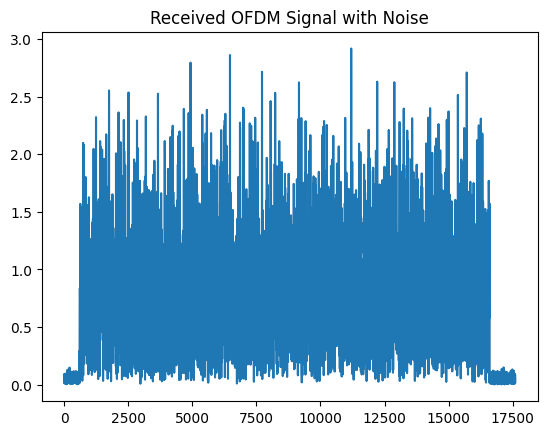

In [488]:
plt.figure(1) 
plt.plot(abs(final_signal))
plt.title('Received OFDM Signal with Noise')

In [489]:
def plot_subcarrier_power_improved(power_matrix, ifft_size, num_symbols_actual):
    power_db = 10 * np.log10(power_matrix + 1e-12)  # avoid log(0)

    plt.figure(figsize=(12, 5))
    extent = [0, num_symbols_actual, 0, ifft_size]

    # Use jet colormap for better contrast
    im = plt.imshow(
        power_db.T,
        aspect='auto',
        extent=extent,
        origin='lower',
        cmap='jet',
        vmin=np.max(power_db) - 40,
        vmax=np.max(power_db)
    )

    plt.title('Subcarrier Power Spectrum (dB)', fontsize=14)
    plt.xlabel('OFDM Symbol Index', fontsize=12)
    plt.ylabel('Subcarrier Index', fontsize=12)
    plt.colorbar(im, label='Power (dB)')

    plt.grid(False)
    plt.tight_layout()
    plt.show()



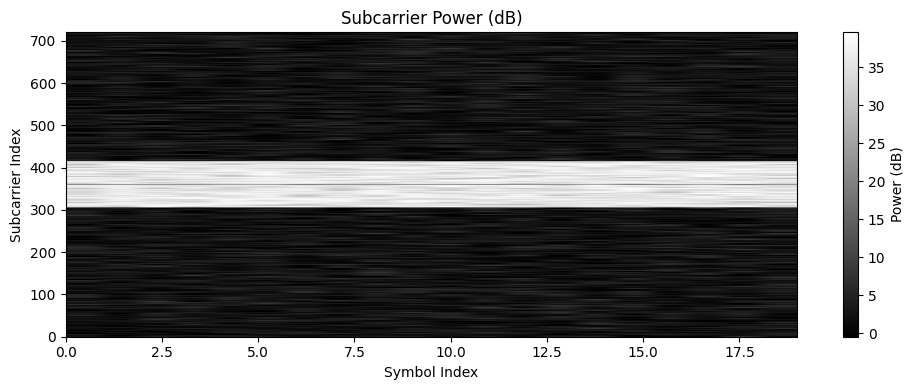

In [490]:
plot_subcarrier_power(full_power, ifft_size=720, num_symbols_actual=20)


In [491]:
def plot_autocorrelation(signal, max_lag=None):
    N = len(signal)
    if max_lag is None:
        max_lag = N // 2

    # Compute full autocorrelation (normalized)
    corr = np.correlate(signal, signal, mode='full')  # length: 2N - 1
    lags = np.arange(-N + 1, N)
    corr = corr / np.max(np.abs(corr))  # Normalize to max=1 (coeff mode)

    # Keep only positive lags
    positive_lags = lags >= 0
    lags_positive = lags[positive_lags][:max_lag]
    Rxx_positive = corr[positive_lags][:max_lag]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(lags_positive, np.abs(Rxx_positive))
    plt.title('Autocorrelation of the Received Signal')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation Coefficient')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


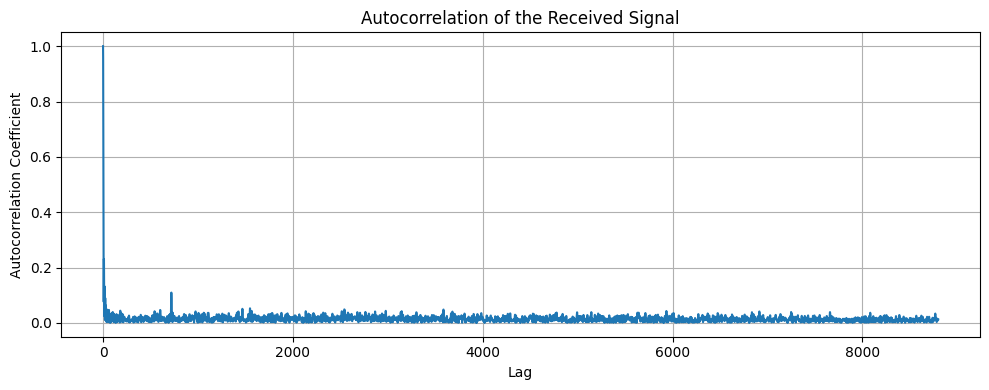

In [492]:
plot_autocorrelation(final_signal)


In [ ]:
def plot_psd_strictly_symmetric(power_matrix, ifft_size, fs=1.0):
    """
    Plot PSD with guaranteed symmetry around 0 Hz.
    """
    # Step 1: Average power over OFDM symbols
    avg_power = np.mean(power_matrix, axis=0)

    # Step 2: Shift power so DC is centered
    psd_shifted = np.fft.fftshift(avg_power) / (fs / ifft_size)
    psd_db = 10 * np.log10(psd_shifted + 1e-12)

    # Step 3: Create symmetric frequency axis (avoids asymmetry from fftfreq)
    if ifft_size % 2 == 0:
        # Even size
        freq_axis = np.linspace(-fs/2, fs/2, ifft_size, endpoint=False)
    else:
        # Odd size: ensure 0 Hz is centered
        freq_axis = np.linspace(-fs/2, fs/2, ifft_size)

    # Step 4: Plot
    plt.figure(figsize=(10, 4))
    plt.plot(freq_axis, psd_db, linewidth=1.2)
    plt.title('Power Spectral Density (dB/Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (dB/Hz)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


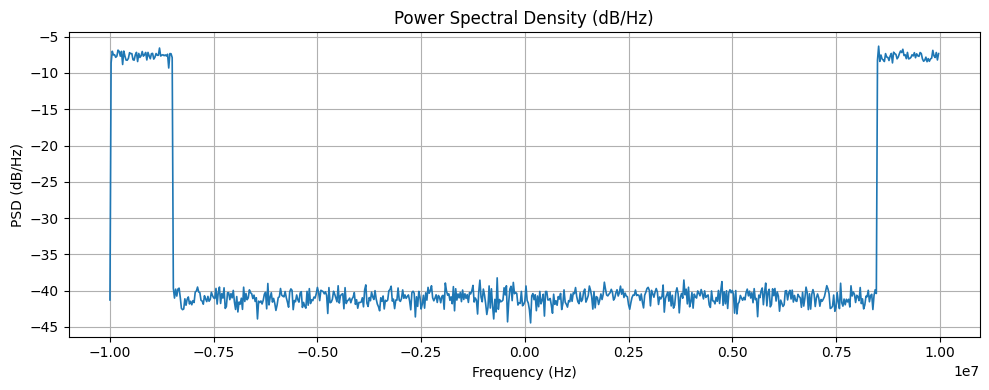

In [494]:
plot_psd_strictly_symmetric(power_matrix, ifft_size=720, fs=20e6)


In [495]:
def plot_constellation(X_fft, active_subcarriers):
    # Step 1: Extract symbols from active subcarriers (avoid DC, guard bands)
    rx_constellation = X_fft[:, active_subcarriers]  # shape: [num_symbols, num_active]

    # Step 2: Flatten to 1D array
    rx_symbols_flat = rx_constellation.flatten()

    # Step 3: Determine scaling for axis limits
    avg_power = np.mean(np.abs(rx_symbols_flat)**2)
    scale = 2 * np.sqrt(avg_power)

    # Step 4: Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(rx_symbols_flat.real, rx_symbols_flat.imag, s=10, c='blue', alpha=0.6)
    plt.title('QPSK Constellation after OFDM Demodulation')
    plt.xlabel('In-phase')
    plt.ylabel('Quadrature')
    plt.grid(True)
    plt.axis('equal')
    plt.xlim([-scale, scale])
    plt.ylim([-scale, scale])
    plt.tight_layout()
    plt.show()


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


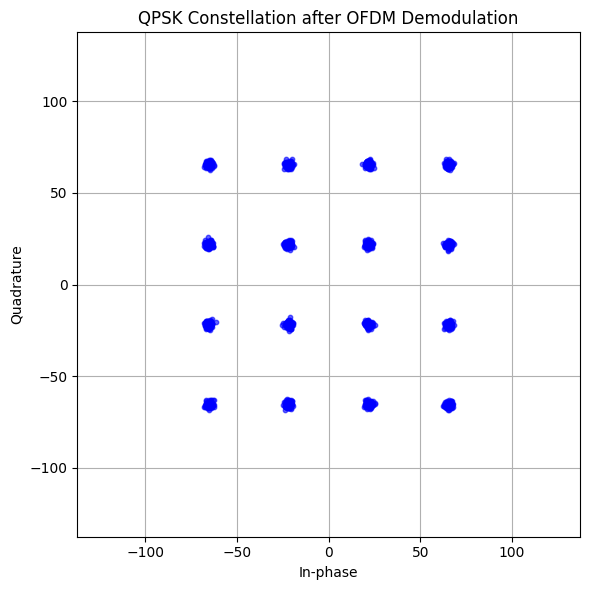

In [496]:
plot_constellation(X_fft, active_subcarriers)


---

# Receiver 

## OFDM Signal Processing (Receiver Side) 

A complete **baseband receiver-side analysis** of an OFDM signal:

* Synchronization via energy threshold and correlation
* CP detection to validate symbol structure
* FFT demodulation for symbol extraction
* Visualization of constellation and power spectrum
* Subcarrier diagnostics for quality inspection

Unkown parameters: 

- CP length
- FFT length
- Symbol start index
- Symbol stop index
- Null subcarriers

### 1. **Signal Preprocessing**

* Load the received signal (input data)
* Define OFDM parameters:
  * Estimate symbol start index 
  * Estimate symbol stop index 
  * Estimate cyclic prefix length for symbols 
  * Estimate total number of symbols

### 2. **Autocorrelation for Rough Symbol Start**

* Compute autocorrelation of the received signal to identify repeating structure.
* Detect the **initial start index** of OFDM symbols based on energy thresholding.
* Use a moving window to refine this estimate.


### 3. **Cyclic Prefix (CP) Correlation-Based Detection**

* Sweep over candidate start indices around the rough estimate.
* For each, check the correlation between CP and end of symbols.
* Select the start index that gives the **maximum average CP correlation**.


### 4. **Symbol Extraction and FFT**

* From the chosen start index, extract all OFDM symbols.
* Remove the cyclic prefix from each.
* Perform FFT on each symbol to transform to the frequency domain.
* Apply `fftshift` to center the DC subcarrier.


### 5. **Constellation Plotting**

* Flatten all subcarriers from all symbols into a single array.
* Plot real vs. imaginary values of subcarriers to visualize:

  * Identify modulation type (e.g., QPSK, QAM)
  * Analyze signal quality and distortions

### 6. **Subcarrier Power Analysis**

* Calculate power per subcarrier for each symbol.
* Identify **low-power (null or attenuated)** subcarriers.
* Use `stem` plots to highlight which subcarriers fall below a threshold (e.g., power < threshold).
* Overplot known null subcarriers for verification.


---

# 1. Signal Preprocessing 

dict_keys(['__header__', '__version__', '__globals__', 'final_signal'])


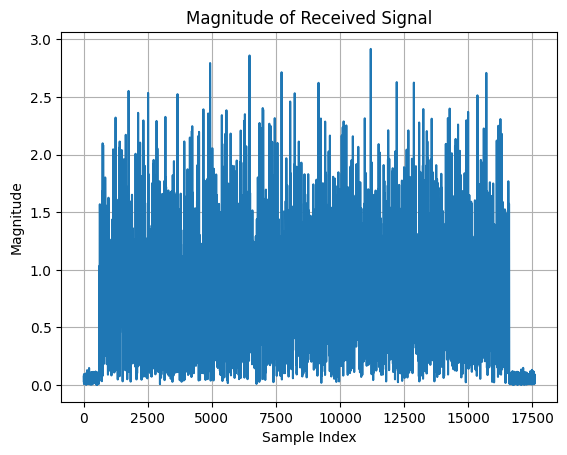

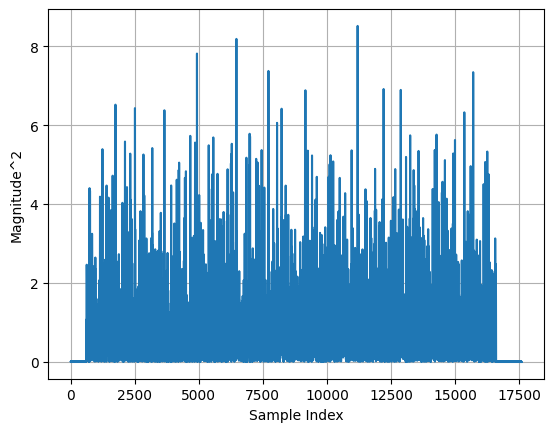

In [498]:
import scipy.io

# Load the received signal
Received = scipy.io.loadmat('OFDM_Rx_Signal.mat')

print(Received.keys())
rx_signal = Received['final_signal']  
rx_signal = rx_signal.squeeze()  # Convert (n,1) to (n,) if needed

plt.figure()
plt.plot(np.abs(rx_signal))  # Magnitude
plt.title('Magnitude of Received Signal')
plt.xlabel('Sample Index')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.abs(rx_signal)**2)  # Magnitude
plt.xlabel('Sample Index')
plt.ylabel('Magnitude^2')
plt.grid(True)
plt.show()


## 2. Autocorrelation Analysis of Received Signal

Computing **autocorrelation** of the received signal to analyze its periodic structure and estimate symbol length.

### Autocorrelation Function

For a real-valued discrete signal $x[n]$, the autocorrelation function $R_{xx}[k]$ is defined as:

$$
R_{xx}[k] = \sum_{n} x[n] \cdot x[n+k]
$$

Where:

* $k$ is the **lag** (shift),
* For negative $k$, we evaluate $x[n] \cdot x[n - |k|]$,
* For normalization (`'coeff'`), we divide by the maximum value of $|R_{xx}[k]|$.

### Why Autocorrelation?

* Peaks in the autocorrelation function at non-zero lags can indicate **periodic patterns**.
* In digital communications, repeated symbol structures create peaks at multiples of **symbol length**.
* Here, a peak at lag = x, suggests the symbol duration is approximately **x samples**.


* Repeated peaks suggest periodicity in the received signal.
* If a peak occurs at lag ≈ x, it implies a **symbol duration** of x samples:

## Start Index Detection Based on Noise Threshold

The **start of the useful signal** in a received waveform based on power thresholding

- Estimate background noise power from the samples.
- Detect where the signal power significantly exceeds the noise.
- Mark and highlight a region around the detected start index.


### Noise Power Estimation

If roughly N samples are noisy samples at the beginning of received signal, then:

$$
P_{\text{noise}} = \frac{1}{N} \sum_{n=1}^{N} |x[n]|^2
$$

Where:

- \( x[n] \) is the received signal,
- \( |x[n]| \) is the magnitude (for complex signals).

### Threshold-Based Detection

We detect the **first index** where the signal power exceeds a multiple of the noise power:

$$
\text{start\_index} = \min \left\{ n : |x[n]|^2 > \text{Threshold} \cdot P_{\text{noise}} \right\}
$$



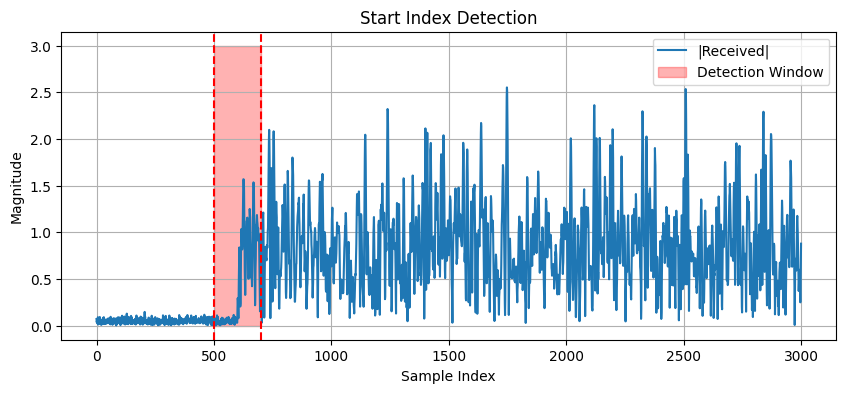

Start Index of Signal: 600


In [ ]:
noise1_power = np.mean(np.abs(rx_signal[:700])**2) 
Threshold = 0.3 # the threshold factor is empirically chosen

# Find the start index where signal power exceeds noise threshold
ind = np.where(np.abs(rx_signal)**2 > Threshold * noise1_power)[0]
start_index = ind[0] if len(ind) > 0 else None

# Plot up to 5×start_index
plt.figure(figsize=(10, 4))
plt.plot(np.abs(rx_signal[:5*start_index]), label='|Received|')
plt.axvline(start_index - 100, color='r', linestyle='--')
plt.axvline(start_index + 100, color='r', linestyle='--')

# Shade the region from (start_index - 100) to (start_index + 100)
x_shade = [start_index - 100, start_index + 100, start_index + 100, start_index - 100]
y_shade = [0, 0, 3, 3]  # Adjust height if needed based on your signal

plt.fill(x_shade, y_shade, color='red', alpha=0.3, label='Detection Window')
plt.title("Start Index Detection")
plt.xlabel("Sample Index")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()
plt.show()
print("Start Index of Signal:", start_index)

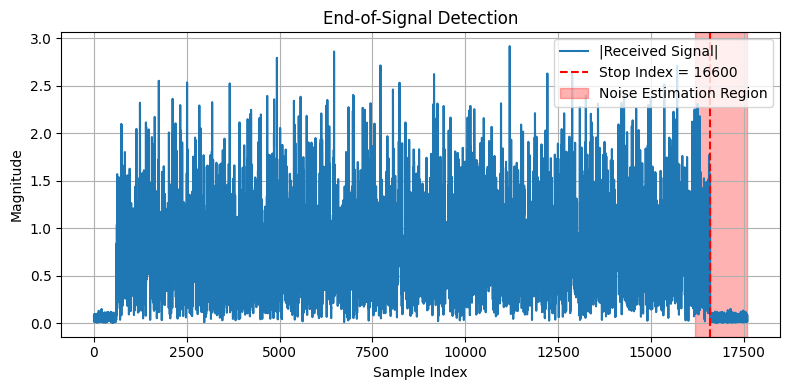

Stop Index: 16600


In [500]:
def detect_end_index(rx_signal, noise_est_start, threshold_factor, plot=True):
    # Estimate noise power from the known tail region
    noise_power = np.mean(np.abs(rx_signal[noise_est_start:])**2)
    threshold = threshold_factor * noise_power
    power = np.abs(rx_signal)**2

    # Set where to start scanning for stop index (e.g., after halfway point)
    search_start = noise_est_start  # or dynamic: len(rx_signal) // 2
    window_len = 400

    stop_index = None
    for i in range(search_start, len(rx_signal) - window_len):
        window = power[i:i+window_len]
        if np.all(window < threshold):
            stop_index = i
            break

    # Plot
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(np.abs(rx_signal), label='|Received Signal|')
        if stop_index:
            plt.axvline(stop_index, color='r', linestyle='--', label=f'Stop Index = {stop_index}')
        plt.axvspan(noise_est_start, len(rx_signal), color='red', alpha=0.3, label='Noise Estimation Region')
        plt.title('End-of-Signal Detection')
        plt.xlabel('Sample Index')
        plt.ylabel('Magnitude')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return stop_index


stop_index = detect_end_index(rx_signal, noise_est_start=16200, threshold_factor=1)
print("Stop Index:", stop_index)



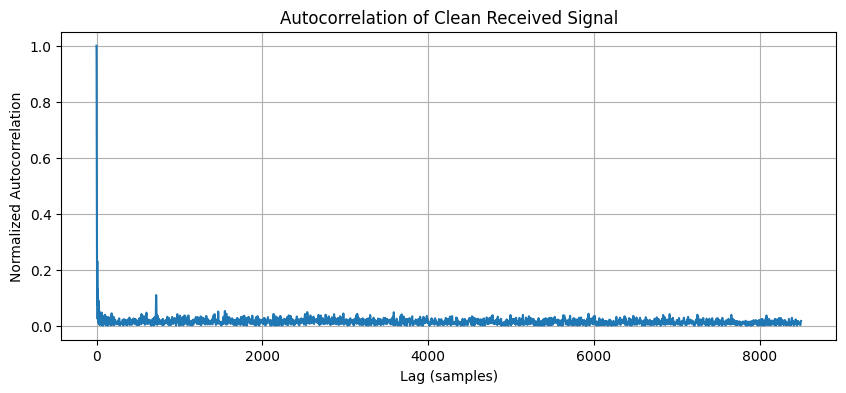

Detected peak lags: [   9  720 1548]
Estimated Symbol Duration: 720 samples


In [512]:
from scipy.signal import find_peaks
rx_clean = rx_signal[start_index:]  # Remove noise before OFDM signal
N = len(rx_clean)
max_lag = N // 2

# Autocorrelation
Rxx_full = np.correlate(rx_clean, rx_clean, mode='full')
lags = np.arange(-N + 1, N)
Rxx_full = Rxx_full / np.max(np.abs(Rxx_full))  # Normalize

# Take positive lags
mid_index = len(Rxx_full) // 2
Rxx_positive = Rxx_full[mid_index:(mid_index + max_lag + 1)]
lags_positive = lags[mid_index:(mid_index + max_lag + 1)]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(lags_positive, np.abs(Rxx_positive))
plt.title('Autocorrelation of Clean Received Signal')
plt.xlabel('Lag (samples)')
plt.ylabel('Normalized Autocorrelation')
plt.grid(True)
plt.show()

# Find peaks
peaks, _ = find_peaks(np.abs(Rxx_positive), height=0.05, distance=300)
peak_lags = lags_positive[peaks]
print("Detected peak lags:", peak_lags)

# Estimate symbol duration
if len(peak_lags) >= 2:
    diffs = np.diff(peak_lags)
    # symbol_duration_est = int(np.median(diffs))
    symbol_duration_est = peak_lags[1]
    print("Estimated Symbol Duration:", symbol_duration_est, "samples")
else:
    print("Not enough peaks found to estimate symbol duration.")


# 3. Cyclic Prefix (CP) Correlation-Based Detection

Implementing a correlation-based search to **refine the start index** of an OFDM-like signal by detecting the **CP** structure within a predefined range.

To scan a window of possible start indices near the initial estimate and find the one that:

- Maximizes **CP autocorrelation**, indicating correct symbol alignment.
- Helps identify where **OFDM symbols** begin reliably.

### OFDM Symbol Structure

- Each symbol has a **CP** prepended.
- CP is a copy of the last part of the symbol.
- This helps mitigate inter-symbol interference (ISI) and aids synchronization.

If  \(L_d\)  is the symbol length and \(L_{cp}\) is the CP length, the total symbol duration is:

$$
T_d = L_{cp} + L_d
$$



### CP Correlation Metric

To detect the symbol start, we compute the **correlation** between:

The **first \( L_{cp} \)** samples of the symbol, and  
The **last \( L_{cp} \)** samples of the same symbol.

$$
\text{Correlation}(L_{cp}) = \left| \sum_{n=0}^{L_{cp}-1} x[n] \cdot x^*[T_d - L_{cp} + n] \right|
$$

This is computed for several symbols and averaged across symbols to smooth the estimate.


### Assumptions

- Each OFDM-like symbol has length `Ld`
- The total symbol duration is `Td = L_cp + Ld`, where `L_cp` is the cyclic prefix.
- The signal starts approximately at sample 398.


For a candidate CP length `L_cp`, and a symbol starting at index \( i \), the **cyclic prefix correlation** is:

$$
Correlation(L_{cp}, i) = | sum( conj(x[0:L_{cp}]) * x[-L_{cp}:] ) |
$$

Where:

- `x` is the signal segment of one symbol of length `Td = L_cp + Ld`,

- `x[0:L_cp]` is the start (prefix),

- `x[-L_cp:]` is the end (suffix),

- The correlation magnitude evaluates cyclic similarity.

### Algorithm Steps

1. **Scan candidate start indices** from `start_index - 100` to `start_index + 100`.

2. For each candidate `j`, extract the signal: `x = rx_signal[j:]`.

3. For each possible CP length 
            $$L_{cp} \in [1, L_d/4]$$

    - Loop over 10 symbols (`i = 1` to `10`).
    - For each symbol, extract the CP and tail, then compute their correlation.


4. Store the **maximum average correlation** across CP lengths for each candidate index.

5. Identify the index with **maximum CP alignment**.



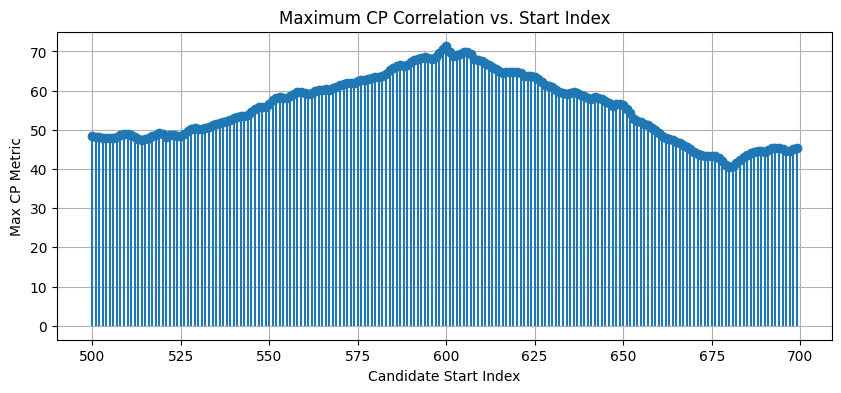

Maximum CP Metric = 71.45 at index = 600


In [513]:
Signal = rx_signal
Ld = symbol_duration_est
mm = [] # maximum metric for CP
search_range = range(start_index - 100, start_index + 100)

# Loop over potential start indices around estimated start_index
for j in search_range:
    x = Signal[j:]
    c = np.zeros((Ld // 4, 10))  # Rows: possible CP lengths, Cols: symbols (3 to 18)

    for i in range(1, 10):  # symbol indices
        for cp_len in range(1, Ld // 4 + 1):
            Td = cp_len + Ld
            start = (i - 1) * Td
            end_ = i * Td
            if end_ > len(x):
                continue
            x1 = x[start:end_]
            c[cp_len - 1, i] = np.abs(np.sum(np.conj(x1[:cp_len]) * x1[-cp_len:]))

    cp_avg = np.mean(c, axis=1)
    mm.append(np.max(cp_avg))

j_range = list(search_range)
mm = np.array(mm)

plt.figure(figsize=(10, 4))
plt.stem(j_range, mm, linefmt='C0-', markerfmt='C0o', basefmt=" ")
plt.title("Maximum CP Correlation vs. Start Index")
plt.xlabel("Candidate Start Index")
plt.ylabel("Max CP Metric")
plt.grid(True)
plt.show()

# Best start
mm_max_idx = j_range[np.argmax(mm)]
print(f"Maximum CP Metric = {np.max(mm):.2f} at index = {mm_max_idx}")

# print("prvious start index:", start_index)
# print("new start index:", mm_max_idx)
# start_index = mm_max_idx + 1


### Cyclic Prefix Estimation for Fixed Start Index

Examining the structure of an OFDM-like signal starting from a fixed `start_index` to evaluate the correlation between the cyclic prefix and the end of each symbol.

- Detect if the signal exhibits repeated cyclic structure.
- Plot correlation metrics per symbol.
- Average correlation results to validate CP length estimation.


### Algorithm

1. For each symbol index `i = 1` to `10`:

   - Try all possible CP lengths from 1 to `Ld / 4`.

   - Extract the full symbol of length `Td = L_cp + Ld`.

   - Compute correlation between prefix and suffix.

   - Store result in a matrix `c`.

2. Plot correlation profile for each symbol:

   - X-axis: CP length candidate
   - Y-axis: Correlation magnitude

3. Average the CP correlation results over all symbols:

   - This helps remove noise and verify stable structure.

4. Report maximum averaged correlation:

   - Indicates strongest CP candidate for alignment.



This analysis helps visually verify whether a **cyclic prefix structure** exists and if the starting point is aligned with the symbol boundary.

- Sharp peaks in correlation plots confirm cyclic structure.
- High average correlation across multiple symbols suggests reliable CP detection.


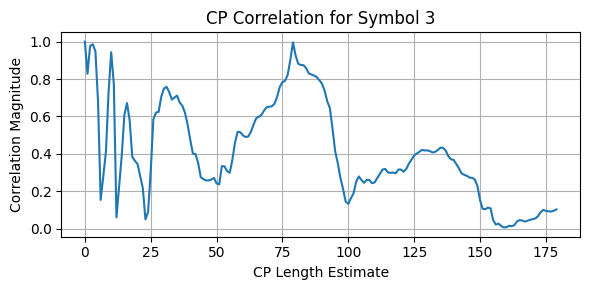

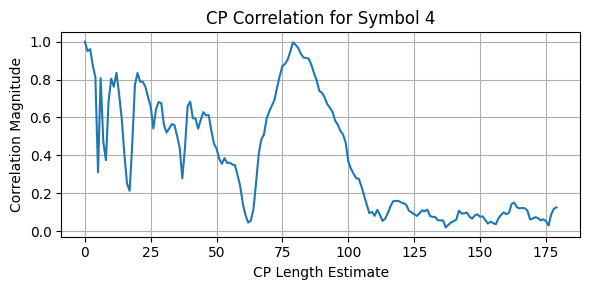

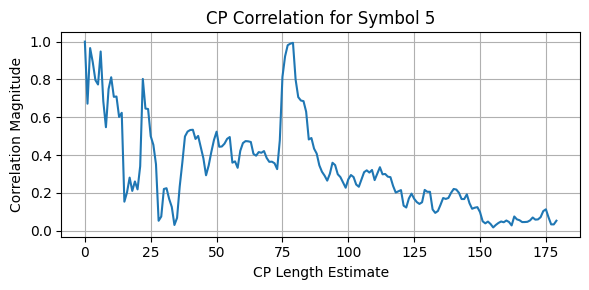

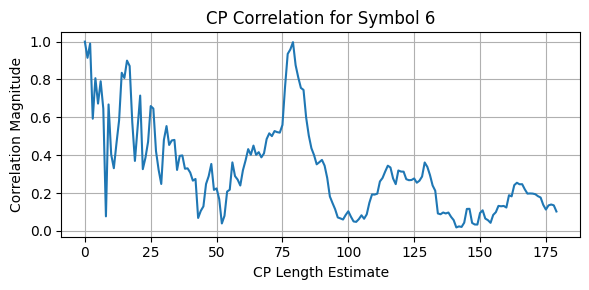

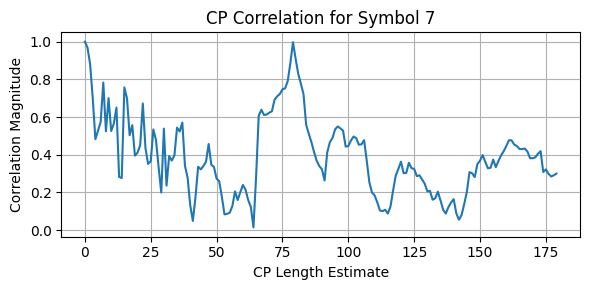

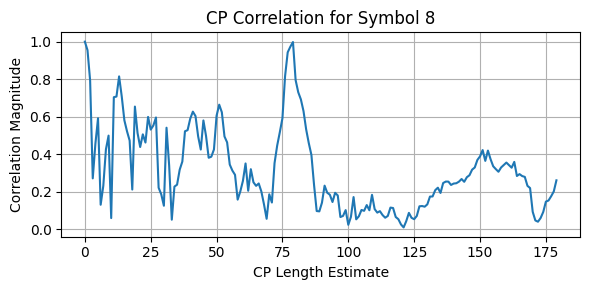

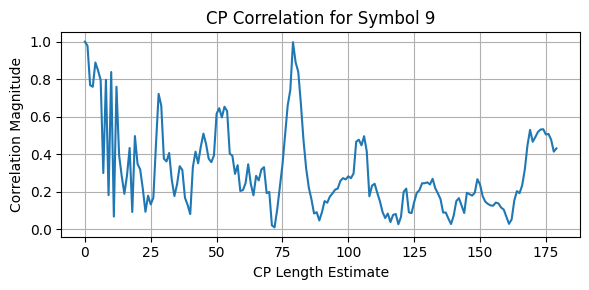

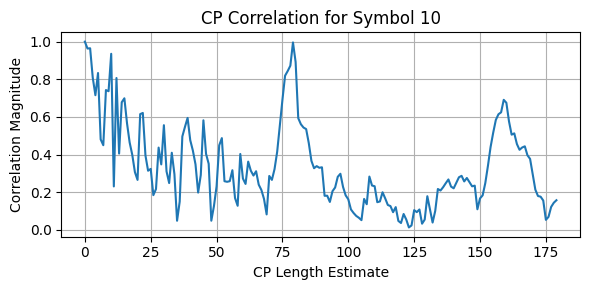

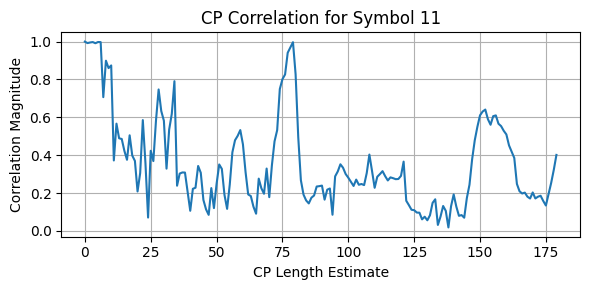

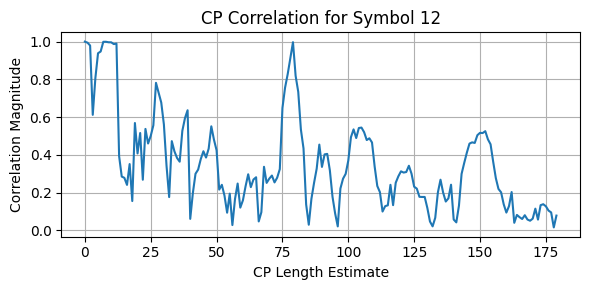

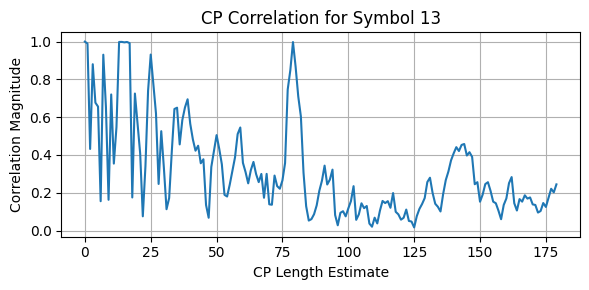

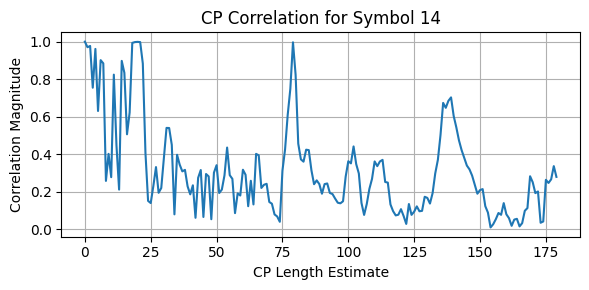

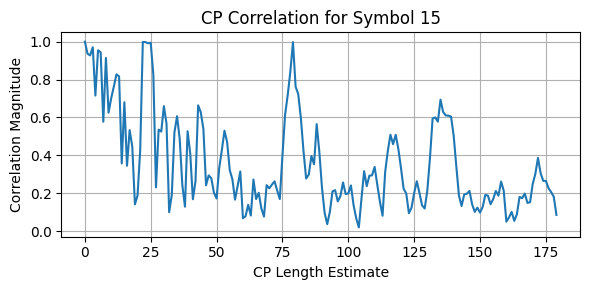

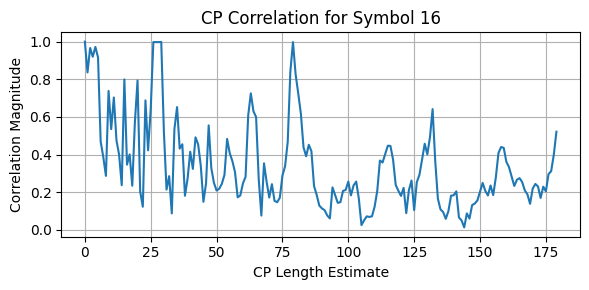

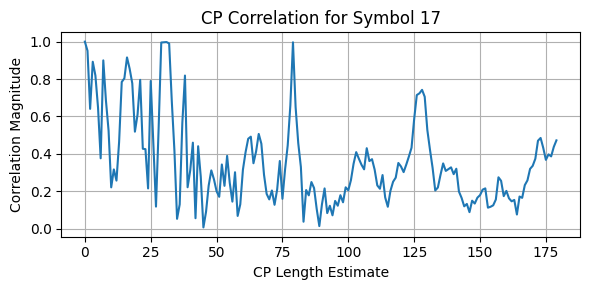

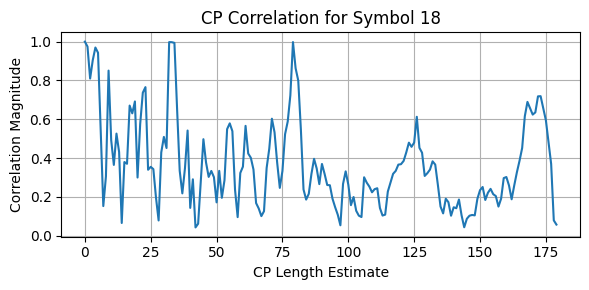

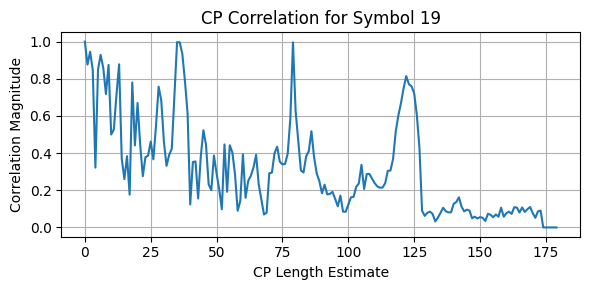

Max averaged CP correlation: 0.8947
Estimated CP Length: 80 samples
Edtimated Symbol Length, Ld:  640
Estimated Symbol Length + CP, Td:  720


In [514]:
x = Signal[start_index:]
c = np.zeros((Ld // 4, 19))  # Rows: CP lengths, Cols: symbol instances 

# Process each symbol index from 3 to 20
for i in range(3, 20):
    for cp_length_est in range(1, Ld // 4 + 1):
        Td = cp_length_est + Ld  # Total duration of one symbol with CP
        start = (i - 1) * Td
        end_ = i * Td
        if end_ > len(x):  # Safety check
            continue
        x1 = x[start:end_]
        a = x1[:cp_length_est]
        b = x1[-cp_length_est:]
        numer = np.sum(np.conj(a) * b)
        denom = np.sqrt(np.sum(np.abs(a)**2) * np.sum(np.abs(b)**2))
        c[cp_length_est - 1, i-1] = np.abs(numer / denom)

    # Plot each symbol's CP correlation profile
    plt.figure(figsize=(6, 3))
    plt.plot(c[:, i - 1])
    plt.title(f"CP Correlation for Symbol {i}")
    plt.xlabel("CP Length Estimate")
    plt.ylabel("Correlation Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Average CP correlation across symbols
cp_avg = np.mean(c[:, :20], axis=1)  # Use only columns 0–7 (symbols 1 to 8)

# Store maximum correlation (for this fixed start_index)
mm_val = np.max(cp_avg)
print(f"Max averaged CP correlation: {mm_val:.4f}")
# Find CP length corresponding to maximum average correlation

min_cp = 4  # Avoid CP = 1–3
search_range = np.arange(min_cp, Ld // 4 + 1)
valid_cp_avg = cp_avg[min_cp - 1:]  # cp_avg[3:] if min_cp = 4
cp_index = np.argmax(valid_cp_avg)
estimated_cp_length = search_range[cp_index]
print(f"Estimated CP Length: {estimated_cp_length} samples")
print("Edtimated Symbol Length, Ld: ", symbol_duration_est - estimated_cp_length)
print("Estimated Symbol Length + CP, Td: ", symbol_duration_est)



## 5. OFDM Symbol Extraction and Constellation Plotting

This process analyzes an OFDM-like signal by segmenting it into symbols, removing CP, performing FFT, and plotting the constellation diagram to visualize modulation characteristics.

- Support symbol extraction at different downsampling factors `k`.
- Apply CP removal and FFT per symbol.
- Flatten the frequency-domain symbols into one array.
- Plot the resulting constellation.


### Steps

1. **Symbol Slicing**

   From the signal $x[n]$, we extract an integer number of symbols:

   $$
   \text{total\_length} = \text{num\_symbols} \times L_s
   $$

   Then reshape into matrix $x_{\text{symbols}} \in \mathbb{C}^{L_s \times N_{\text{sym}}}$.

2. **CP Removal**

   Remove first `Lcp` samples of each symbol:

   $$
   x_{\text{no\_cp}} = x_{\text{symbols}}[L_{\text{cp}}:, :]
   $$

3. **FFT per Symbol**

   Apply FFT to each column (symbol):

   $$
   X_k = \text{FFT}(x_{\text{no\_cp}}[:, k])
   $$

4. **FFT Shift**

   Center the DC component using `fftshift`.

5. **Flatten Constellation**

   Flatten all subcarriers from all symbols:

   $$
   \text{constellation\_points} = \text{flatten}(X_{\text{symbols}})
   $$

Processing for k = 1
  Lcp = 80, Ld = 720, Ls = 800
 num_symbols = 20
  Start index = 600


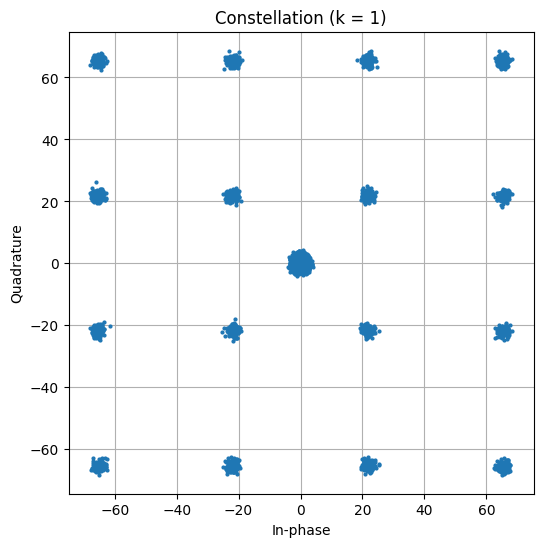

In [515]:
x_raw = rx_signal

# Optional: visualize multiple downsampling factors
for k in [1]:  # You can extend to [1, 2, 4, 5, 8, 10, 16, 20, 40]
    print(f"Processing for k = {k}")

    Lcp = int(estimated_cp_length/k)
    Ld = int(symbol_duration_est/k)
    Ls = Lcp + Ld  # Total symbol length
    print(f"  Lcp = {Lcp}, Ld = {Ld}, Ls = {Ls}")
    # print("start_index :", start_index)
    # print("stop index :", stop_index)
    signal_length = stop_index - start_index; #Total samples in signal
    num_symbols = int(signal_length / Ls); # Only complete symbols
    print(f" num_symbols = {num_symbols}")

    # Optional: downsampling
    x = x_raw[::k]
    for indd in [start_index]:
        print(f"  Start index = {indd}")
        x = x_raw[indd:]
        N = len(x)
        # num_symbols = len(x) // Ls  # Fixed manually
        total_length = num_symbols * Ls

        if total_length > N:
            print("  Not enough data to extract symbols.")
            continue

        x_truncated = x[:total_length]

        # Reshape into symbols: shape = (Ls, num_symbols)
        x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')

        # Remove CP from each symbol (result: shape = (Ld, num_symbols))
        x_no_cp = x_symbols[Lcp:, :]

        # Perform FFT on each column (along rows)
        X_symbols = np.fft.fft(x_no_cp, n=Ld, axis=0)

        # Shift frequency spectrum (zero-freq to center)
        X_symbols = np.fft.fftshift(X_symbols, axes=0)

        # Flatten to 1D vector
        constellation_points = X_symbols.flatten()

        # Plot the constellation
        plt.figure(figsize=(6, 6))
        plt.plot(np.real(constellation_points), np.imag(constellation_points), 'o', markersize=2)
        plt.title(f'Constellation (k = {k})')
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.grid(True)
        plt.axis('equal')
        plt.show()



## 6. OFDM Demodulation and Constellation Plotting

### Signal Segmentation and FFT

Implementation of an OFDM demodulation process that uses multiple start indices to extract frequency-domain constellation points.

- Refine symbol synchronization using multiple candidate start indices.
- Demodulate OFDM-like symbols by removing the cyclic prefix and performing FFT.
- Visualize constellation points for quality analysis of the modulation scheme.

### Parameters

   - **Downsampling factor (k):** Determines resolution. Only `k = 1` is used in this run.
   - **Cyclic Prefix (CP) length:** `Lcp = Lcp / k`
   - **Data symbol length (Ld):** `Ld = Lc / k`
   - **Total symbol length:** `Ls = Lcp + Ld`
   - **Start indices tested:** `indd ∈ [start_index+1, start_index+2, start_index+3]`
   - **Number of symbols:** Fixed at 21



1. **Start Index Selection**

   - For each `indd` in the range `[start_index+1, start_index+2, start_index+3]`, the signal is processed from that point onward.
   - This tests alignment sensitivity.

2. **Signal Truncation**

   - Extract a fixed number of complete OFDM symbols (21 symbols of length `Ls`).
   - The signal is reshaped into a 2D matrix of size `(Ls, num_symbols)`.

3. **Cyclic Prefix Removal**

   - For each symbol, remove the first `Lcp` samples.
   - Resulting matrix has shape `(Ld, num_symbols)`.

4. **FFT Processing**

   - Apply FFT to each symbol column to transform into the frequency domain.
   - Use `fftshift` to center the DC component.

5. **Flatten and Plot**

   - Flatten the matrix into a 1D array of constellation points.
   - Plot the real vs. imaginary parts to visualize modulation (e.g., QPSK, 16-QAM).




Processing with k=1, Lcp=80, Ld=720, Ls=800
 num_symbols = 20
  Processing start index: 599


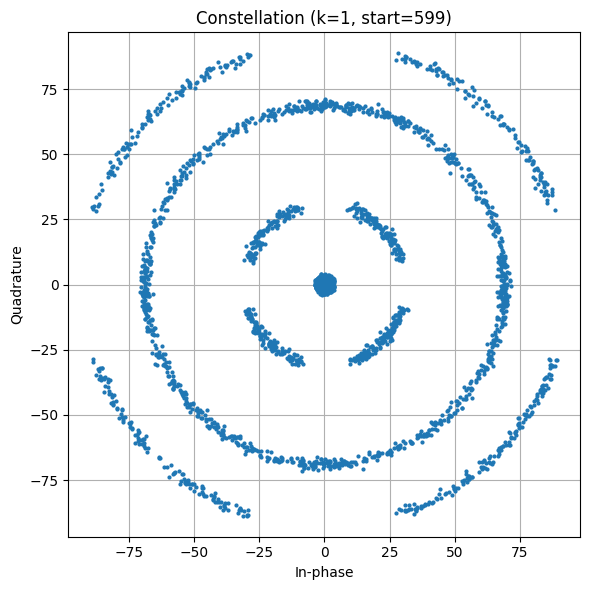

  Processing start index: 600


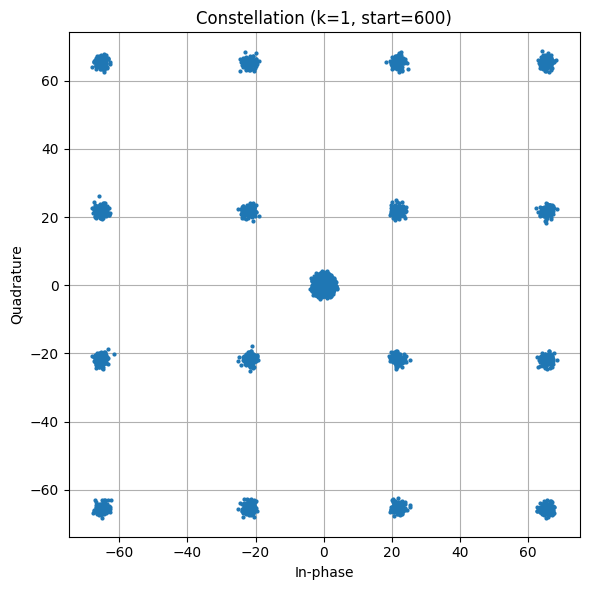

  Processing start index: 601


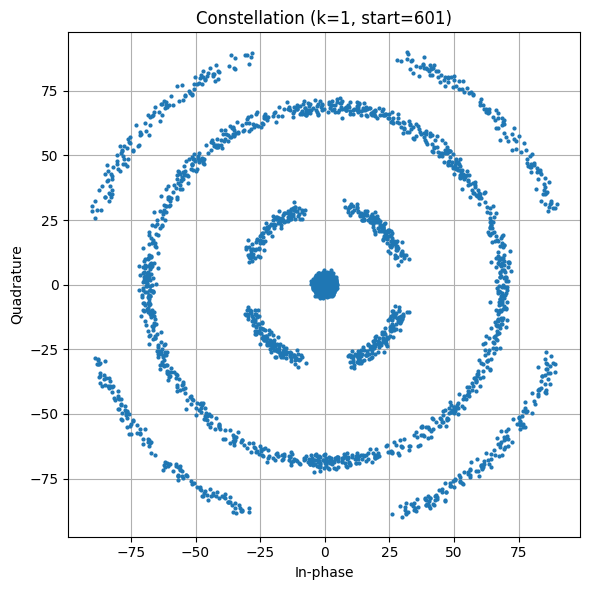

  Processing start index: 602


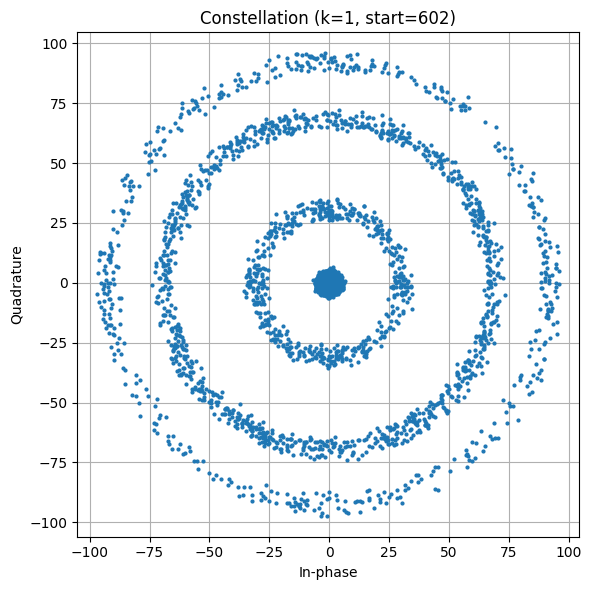

In [516]:
for k in [1]:
    Lcp = int(Lcp / k)  # Adjusted CP length
    Ld = int(Ld / k)  # Adjusted data (useful symbol) length
    Ls = Lcp + Ld      # Total OFDM symbol length
    print(f"\nProcessing with k={k}, Lcp={Lcp}, Ld={Ld}, Ls={Ls}")
    print(f" num_symbols = {num_symbols}")

    # Downsampled version (optional)
    x_down = x_raw[::k]

    for indd in range(start_index-1, start_index + 3):  
        print(f"  Processing start index: {indd}")
        x = x_raw[indd:]
        N = len(x)
        total_length = num_symbols * Ls

        if total_length > N:
            print("  Skipping: Not enough data.")
            continue

        # Truncate signal to complete symbols
        x_truncated = x[:total_length]

        # Reshape into (Ls, num_symbols) matrix
        x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')

        # Remove CP from each symbol → shape (Ld, num_symbols)
        x_no_cp = x_symbols[Lcp:, :]

        # Apply FFT on each symbol (column-wise)
        X_symbols = np.fft.fft(x_no_cp, n=Ld, axis=0)

        # Shift zero-frequency to center
        X_symbols = np.fft.fftshift(X_symbols, axes=0)

        # Flatten to form 1D list of constellation points
        constellation_points = X_symbols.flatten()

        # Plot
        plt.figure(figsize=(6, 6))
        plt.plot(np.real(constellation_points), np.imag(constellation_points), 'o', markersize=2)
        plt.title(f'Constellation (k={k}, start={indd})')
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()



## 7. Subcarrier Power Analysis 

### OFDM Demodulation with Subcarrier Power Analysis

OFDM demodulation on a received signal with:

- Cyclic prefix removal
- FFT and FFT shift
- Power thresholding on subcarriers
- Visualization of low-power carriers and frequency-domain content


- Identify weak subcarriers (e.g., due to fading or zero-padding)
- Plot per-symbol power spectrum
- Visualize constellation of demodulated symbols



### Parameters

- **Downsampling factor (k):** 1
- **Cyclic prefix (CP):** `Lcp = Lcp / k`
- **Data symbol length:** `Ld = Ld / k`
- **Total symbol length:** `Ls = Lcp + Ld`
- **Start index (`indd`)**: `start_index`
- **Number of symbols processed**: estimated_symbols


### Processing Steps

1. **Signal Extraction**
   - Slice signal from `indd` onward.
   - Truncate to `total_length = num_symbols * Ls`.

2. **Reshape into Symbols**
   - Reshape into a matrix: `x_symbols ∈ ℂ^{Ls × num_symbols}`.
   - Remove CP: `x_no_cp = x_symbols[Lcp:, :]`.

3. **Frequency-Domain Transformation**
   - Perform FFT on each column (symbol).
   - Apply `fftshift` to center DC component.

4. **Low-Power Subcarrier Detection**
   - Compute magnitude squared of each FFT bin.
   - Identify entries where power `< 20`.
   - Plot with a **stem plot**:
     - X-axis: Symbol index
     - Y-axis: Subcarrier index


5. **Per-Symbol Power Spectrum**
   - Plot power of all subcarriers across symbols 1 to estimated_symbols.
   - Each curve shows the subcarrier power for one OFDM symbol.

6. **Constellation Visualization**
   - Flatten the FFT matrix.
   - Plot real vs. imaginary components of all subcarriers to assess:
     - Modulation type
     - Noise and phase distortion


## Use Cases

- Check spectral nulls or filter effects
- Evaluate subcarrier energy distribution
- Validate modulation under different timing assumptions

   - Extend `k` to other values for resolution studies.
   - Adjust power threshold (`< 20`) for more or fewer detected subcarriers.



Processing with k=1, Lcp=80, Ld=720, Ls=800


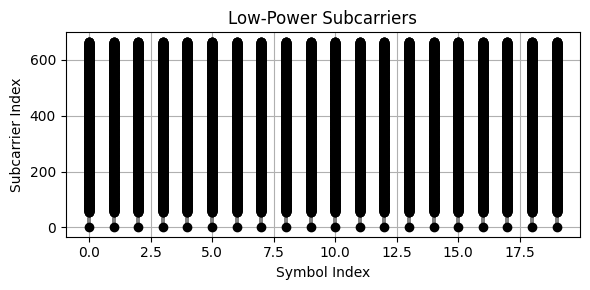

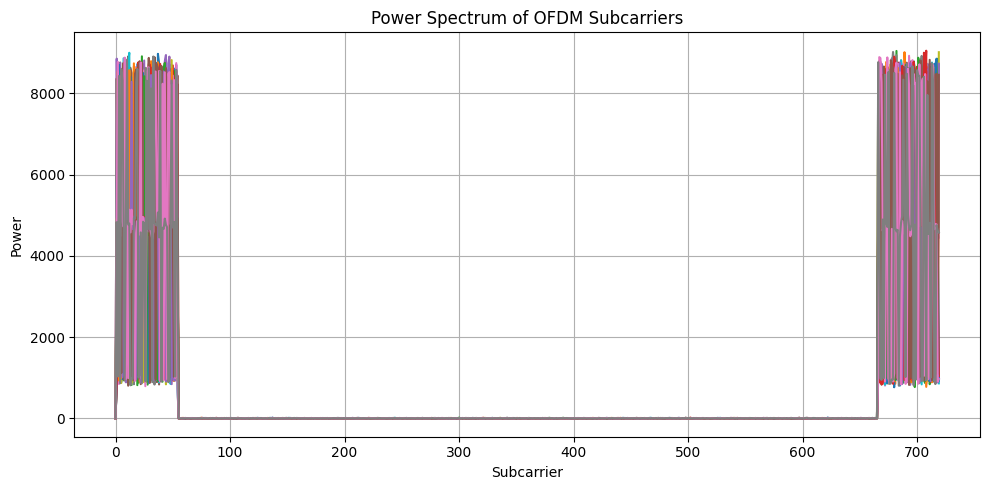

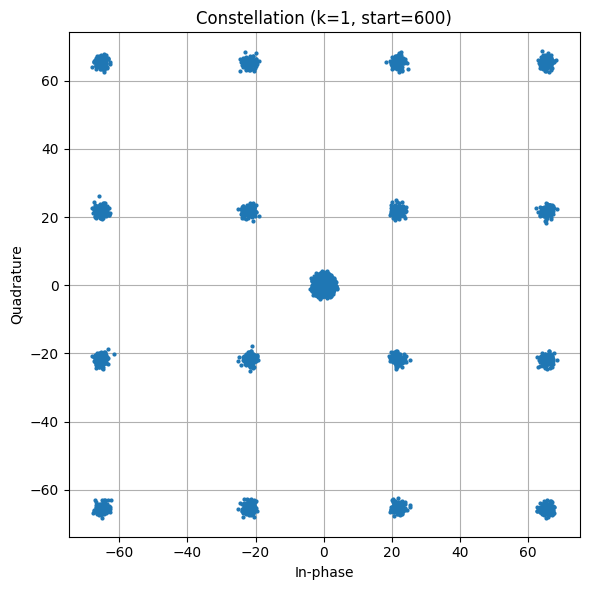

In [519]:
for k in [1]:

    print(f"\nProcessing with k={k}, Lcp={Lcp}, Ld={Ld}, Ls={Ls}")

    x_down = x_raw[::k]

    for indd in [start_index]:
        x = x_raw[indd:]
        N = len(x)
        # num_symbols = estimated_symbols
        total_length = num_symbols * Ls

        if total_length > N:
            print("Not enough data for full symbols")
            continue

        x_truncated = x[:total_length]
        x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')
        x_no_cp = x_symbols[Lcp:, :]  # shape: (Ld, num_symbols)

        # FFT + fftshift
        X_symbols = np.fft.fftshift(np.fft.fft(x_no_cp, n=Ld, axis=0), axes=0)

        # Detect low-power subcarriers (|X|^2 < 20)
        magnitude_squared = np.abs(X_symbols)**2
        rows, cols = np.where(magnitude_squared < 20)

        # Stem plot of low-power subcarriers
        plt.figure(figsize=(6, 3))
        plt.stem(cols, rows, linefmt='gray', markerfmt='ko', basefmt=' ')
        plt.title('Low-Power Subcarriers')
        plt.xlabel('Symbol Index')
        plt.ylabel('Subcarrier Index')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Per-symbol power spectrum
        plt.figure(figsize=(10, 5))
        for l in range(2, num_symbols): 
            plt.plot(range(Ld), magnitude_squared[:, l])
        plt.xlabel('Subcarrier')
        plt.ylabel('Power')
        plt.title('Power Spectrum of OFDM Subcarriers')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Flatten for constellation plot
        constellation_points = X_symbols.flatten()

        # Plot constellation
        plt.figure(figsize=(6, 6))
        plt.plot(np.real(constellation_points), np.imag(constellation_points), 'o', markersize=2)
        plt.title(f'Constellation (k={k}, start={indd})')
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

### Possible Cause of the Central Cluster: 

#### 1. DC subcarrier 

Noise and channel effects can cause DC bin to accumulate energy at the receiver. 

#### 2. Inactive or zeroed subcarriers: 

Many subcarriers are intentionally zeroed (guard bands) 
After passing through a channel (and added noise), those subcarriers can have small non-zero values which cluster zero. 

We must plot only the active subcarriers. 

#### 3. Noise Leakage: 

If SNR is moderate, noise leaks into zeroed bins and we'll see a noisy zero-energy cluster around 0,0

#### 4. Receiver demodulating blindly: 

If receiver blindly demodulates all 720 FFT outputs, we'll naturally get a lot of low-energy noisy points, especially at inactive bins. 


